<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: PCA Visualization and Horn's Parallel Analysis

_Author: Kiefer Katovich (SF)_

---

**Outline:**

- [Part I](#parti): Guided PCA example with the [heptathlon performance data set](./datasets/heptathlon.csv).
- [Part II](#partii): Try PCA yourself with the [wine quality data set](./datasets/wine_quality.csv).
- [Part III](#partiii): Use Horn's parallel analysis to select the number of components.

**In this lab, we will:**

- Practice cleaning data.
- Perform PCA and interpret the principal components.
- Validate PCA results using visualizations and intuition.
- Select the number of principal components using elbow plots and Horn's parallel analysis.

_Horn's parallel analysis_ is a way to determine how many components you should keep after performing PCA on your data. Essentially, it will tell you which of your components are likely noise and can therefore be discarded.


---

<a id="parti"></a>
# Part I: Heptathlon Data Set


### 1) Load packages and heptathlon data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# The athlete names make a natural index and are non-numeric,
#   so there’s no need to exclude them when creating matrices.
hep = pd.read_csv('./datasets/heptathlon.csv', index_col=0)

hep.head(3)

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),12.69,1.86,15.80,22.56,7.27,45.66,128.51,7291
John (GDR),12.85,1.80,16.23,23.65,6.71,42.56,126.12,6897
Behmer (GDR),13.20,1.83,14.20,23.10,6.68,44.54,124.20,6858


---

### 2) Create a DataFrame that excludes `athlete` and `score`.

In [3]:
# Double check the number of entries, the number of null values, and the proper data types.
hep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Joyner-Kersee (USA) to Launa (PNG)
Data columns (total 8 columns):
hurdles     25 non-null float64
highjump    25 non-null float64
shot        25 non-null float64
run200m     25 non-null float64
longjump    25 non-null float64
javelin     25 non-null float64
run800m     25 non-null float64
score       25 non-null int64
dtypes: float64(7), int64(1)
memory usage: 1.8+ KB


In [4]:
hep.head()

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),12.69,1.86,15.80,22.56,7.27,45.66,128.51,7291
John (GDR),12.85,1.80,16.23,23.65,6.71,42.56,126.12,6897
Behmer (GDR),13.20,1.83,14.20,23.10,6.68,44.54,124.20,6858
Sablovskaite (URS),13.61,1.80,15.23,23.92,6.25,42.78,132.24,6540
Choubenkova (URS),13.51,1.74,14.76,23.93,6.32,47.46,127.90,6540


In [5]:
# Note that in some events, a high number is good, whereas in others it’s bad.
# - Javelin is based on distance thrown (higher is better).
# - Shot is based on distance thrown (higher is better).
# - Long jump is based on distance jumped (higher is better).


# Problem: Running events are based on time taken (lower is better).
#   - So, we'll normalize to m/s (higher is better).

hep['hurdles'] = 110. / hep['hurdles']
hep['run200m'] = 200. / hep['run200m']
hep['run800m'] = 800. / hep['run800m']

hep.head()

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),8.668243,1.86,15.80,8.865248,7.27,45.66,6.225196,7291
John (GDR),8.560311,1.80,16.23,8.456660,6.71,42.56,6.343165,6897
Behmer (GDR),8.333333,1.83,14.20,8.658009,6.68,44.54,6.441224,6858
Sablovskaite (URS),8.082292,1.80,15.23,8.361204,6.25,42.78,6.049607,6540
Choubenkova (URS),8.142117,1.74,14.76,8.357710,6.32,47.46,6.254887,6540


---

### 3) Examine the correlation between the different events.

Plot a heat map if you want to visualize the correlation. What does the correlation matrix tell you?

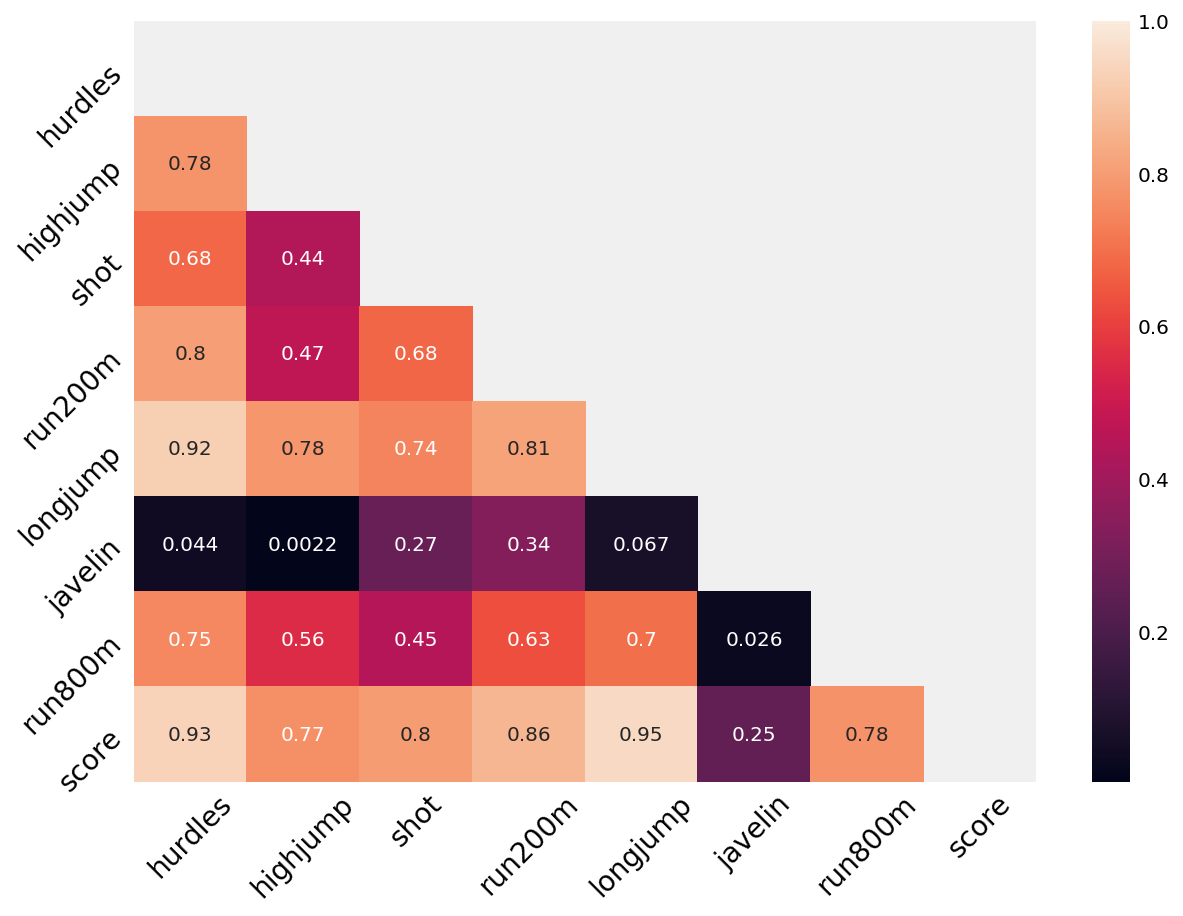

In [7]:
corr = hep.corr()
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=45)
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [2]:
# A:

**Note that all correlations are positive.** Why? 

Recall that we altered the data such that higher numbers always indicate a higher score and likely a better athlete overall.

---

### 4) Standardize the data.

In [8]:
# Split into features and targets.
#   - You can control the order of the event columns by changing their positions here:

EVENT_NAMES = ['hurdles', 'run200m', 'run800m', 'highjump', 'shot', 'longjump', 'javelin']
TARGET_NAMES = ['score']

X = hep[EVENT_NAMES]
X.head()

,hurdles,run200m,run800m,highjump,shot,longjump,javelin
Joyner-Kersee (USA),8.668243,8.865248,6.225196,1.86,15.80,7.27,45.66
John (GDR),8.560311,8.456660,6.343165,1.80,16.23,6.71,42.56
Behmer (GDR),8.333333,8.658009,6.441224,1.83,14.20,6.68,44.54
Sablovskaite (URS),8.082292,8.361204,6.049607,1.80,15.23,6.25,42.78
Choubenkova (URS),8.142117,8.357710,6.254887,1.74,14.76,6.32,47.46


In [31]:
from sklearn.preprocessing import StandardScaler
Xn = StandardScaler().fit_transform(X)
Xn = pd.DataFrame(Xs, columns = X.columns.values)


---

### 5) Fit a PCA on the standardized data using scikit-learn.

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xn)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
pca.components_

array([[-0.4537067 , -0.41103609, -0.37226083, -0.36742524, -0.36917476,
        -0.45596971, -0.08614954],
       [-0.13505313,  0.24712711, -0.17322253, -0.27633985,  0.25347623,
        -0.09221975,  0.86114134],
       [ 0.00846058, -0.09809294,  0.39876187,  0.41435647, -0.67952134,
        -0.11066596,  0.4308221 ],
       [ 0.01388192, -0.3166502 , -0.6411877 ,  0.65705272,  0.14288476,
         0.12238373,  0.14596634],
       [ 0.15563941,  0.64775707, -0.49459184, -0.06564944, -0.51893625,
         0.15926353, -0.11223419],
       [ 0.8317523 , -0.16327155, -0.11449967, -0.12923811,  0.00570046,
        -0.49834774,  0.05774845],
       [ 0.2441538 , -0.46242959, -0.05959757, -0.40523215, -0.21901407,
         0.69472805,  0.16783506]])

In [48]:
pd.DataFrame(pca.components_, columns=X.columns)

,hurdles,run200m,run800m,highjump,shot,longjump,javelin
0,-0.453707,-0.411036,-0.372261,-0.367425,-0.369175,-0.455970,-0.086150
1,-0.135053,0.247127,-0.173223,-0.276340,0.253476,-0.092220,0.861141
2,0.008461,-0.098093,0.398762,0.414356,-0.679521,-0.110666,0.430822
3,0.013882,-0.316650,-0.641188,0.657053,0.142885,0.122384,0.145966
4,0.155639,0.647757,-0.494592,-0.065649,-0.518936,0.159264,-0.112234
5,0.831752,-0.163272,-0.114500,-0.129238,0.005700,-0.498348,0.057748
6,0.244154,-0.462430,-0.059598,-0.405232,-0.219014,0.694728,0.167835


In [34]:
pc1_ev = pca.components_[0]

# A quick way of viewing, rather than looping through each feature:
pd.Series(pc1_ev, index=EVENT_NAMES)

hurdles    -0.453707
run200m    -0.411036
run800m    -0.372261
highjump   -0.367425
shot       -0.369175
longjump   -0.455970
javelin    -0.086150
dtype: float64

In [35]:
pc2_ev = pca.components_[1]

pd.Series(pc2_ev, index=EVENT_NAMES)

hurdles    -0.135053
run200m     0.247127
run800m    -0.173223
highjump   -0.276340
shot        0.253476
longjump   -0.092220
javelin     0.861141
dtype: float64

---

### 6) Create a DataFrame with the principal components.

Add back in the `athlete` and `score` columns from the original data.

In [36]:
pca.components_[0]

array([-0.4537067 , -0.41103609, -0.37226083, -0.36742524, -0.36917476,
       -0.45596971, -0.08614954])

In [37]:
X.head(1)

,hurdles,run200m,run800m,highjump,shot,longjump,javelin
Joyner-Kersee (USA),8.668243,8.865248,6.225196,1.86,15.8,7.27,45.66


In [38]:
hep_pcs = pca.transform(Xn)
hep_pcs = pd.DataFrame(hep_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(EVENT_NAMES))],
                       index=hep.index)
hep_pcs['score'] = hep['score']
hep_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,score
Joyner-Kersee (USA),-4.400791,1.159007,-0.391943,0.055114,0.534981,-0.242880,0.358763,7291
John (GDR),-3.070295,0.449857,-0.901411,-0.521204,-0.714819,0.347712,0.133539,6897
Behmer (GDR),-2.828234,0.670888,0.508974,-0.786620,0.079807,-0.270952,-0.125716,6858
Sablovskaite (URS),-1.356669,0.668543,-0.635637,-0.081463,-0.471548,-0.033753,-0.502329,6540
Choubenkova (URS),-1.431348,1.818897,0.071717,-0.822202,-0.671438,0.127554,0.222916,6540


In [39]:
# Always make sure you verify that your numbers are correct as often as possible!
#   - At a minimum, let's ensure the athletes and scores still match up.
hep.head(2)

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),8.668243,1.86,15.80,8.865248,7.27,45.66,6.225196,7291
John (GDR),8.560311,1.80,16.23,8.456660,6.71,42.56,6.343165,6897


---

### 7) Plot the explained variance (ratio) of your components.

Explain what this chart tells you about your components.

In [40]:
exp_var = pca.explained_variance_ratio_
exp_var

array([0.63832499, 0.16512568, 0.07267193, 0.06981022, 0.03691008,
       0.01029863, 0.00685847])

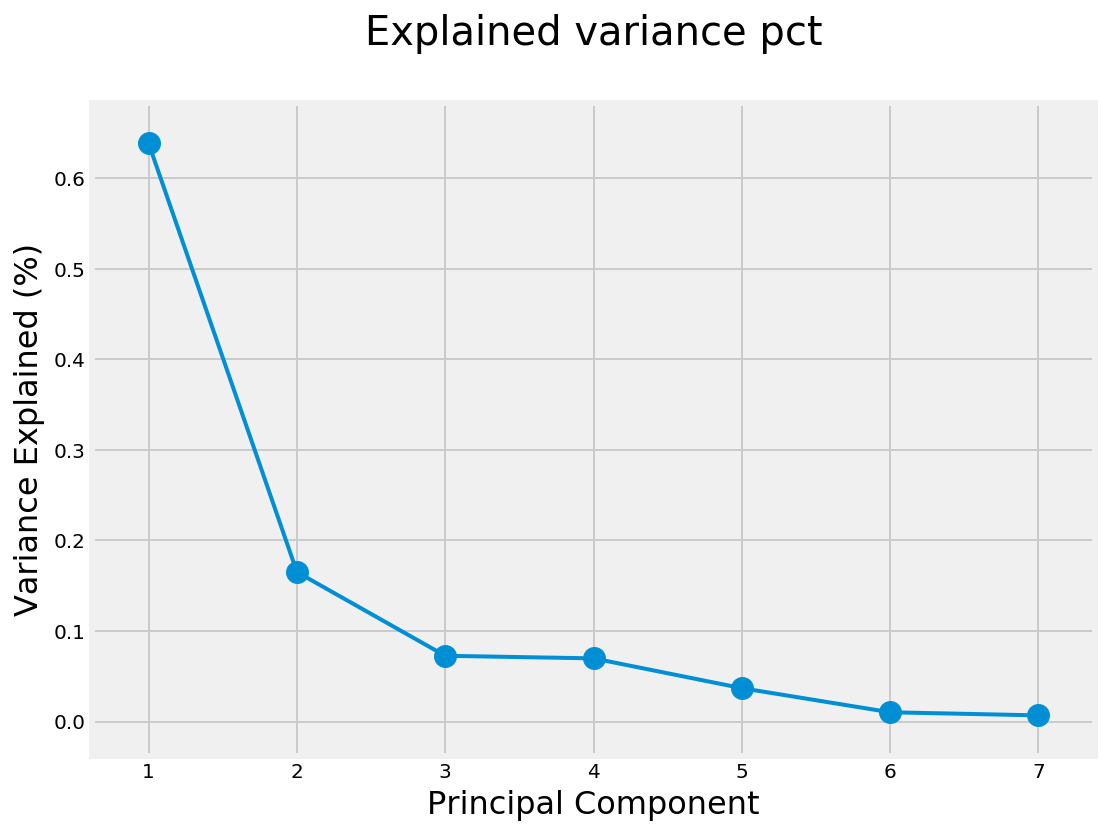

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()

---

### 8) Print out the weights/eigenvectors (`.components_` ) with their corresponding variables for PC1 and PC2.

Based on how the original variables are weighted to calculate the components, how would you describe PC1 and PC2?

In [42]:
# Reminder of PC1 and PC2:

pd.DataFrame({'PC1': pc1_ev, 'PC2': pc2_ev},
             index=EVENT_NAMES)

,PC1,PC2
hurdles,-0.453707,-0.135053
run200m,-0.411036,0.247127
run800m,-0.372261,-0.173223
highjump,-0.367425,-0.276340
shot,-0.369175,0.253476
longjump,-0.455970,-0.092220
javelin,-0.086150,0.861141


PC1 describes athletes who are below the mean in all categories. We will describe them as "below average.”

PC2 describes athletes who are the best at javelin. We will describe them as "javelin.”

---

### 9) Plot PC1 versus PC2. Which athletes are notable on each component?

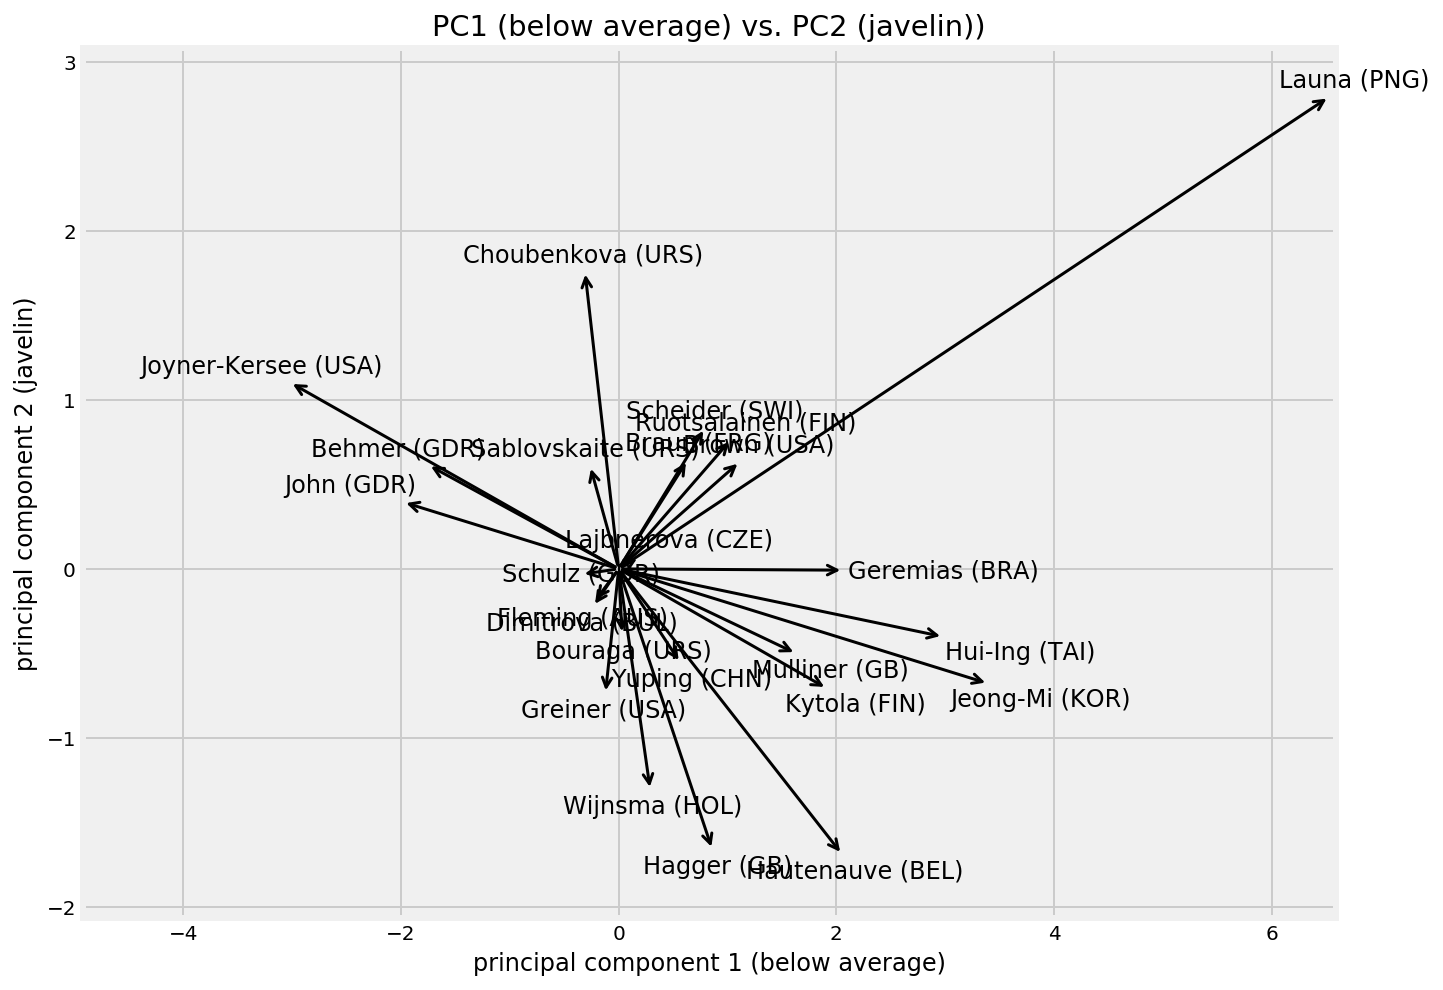

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(hep_pcs.PC1.values, hep_pcs.PC2.values, s=0)

for i, txt in enumerate(hep_pcs.index.values):
    ax.annotate(txt, (0, 0), (hep_pcs.PC1.values[i], hep_pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 (below average) vs. PC2 (javelin))')
ax.set_xlabel('principal component 1 (below average)')
ax.set_ylabel('principal component 2 (javelin)')
plt.show()

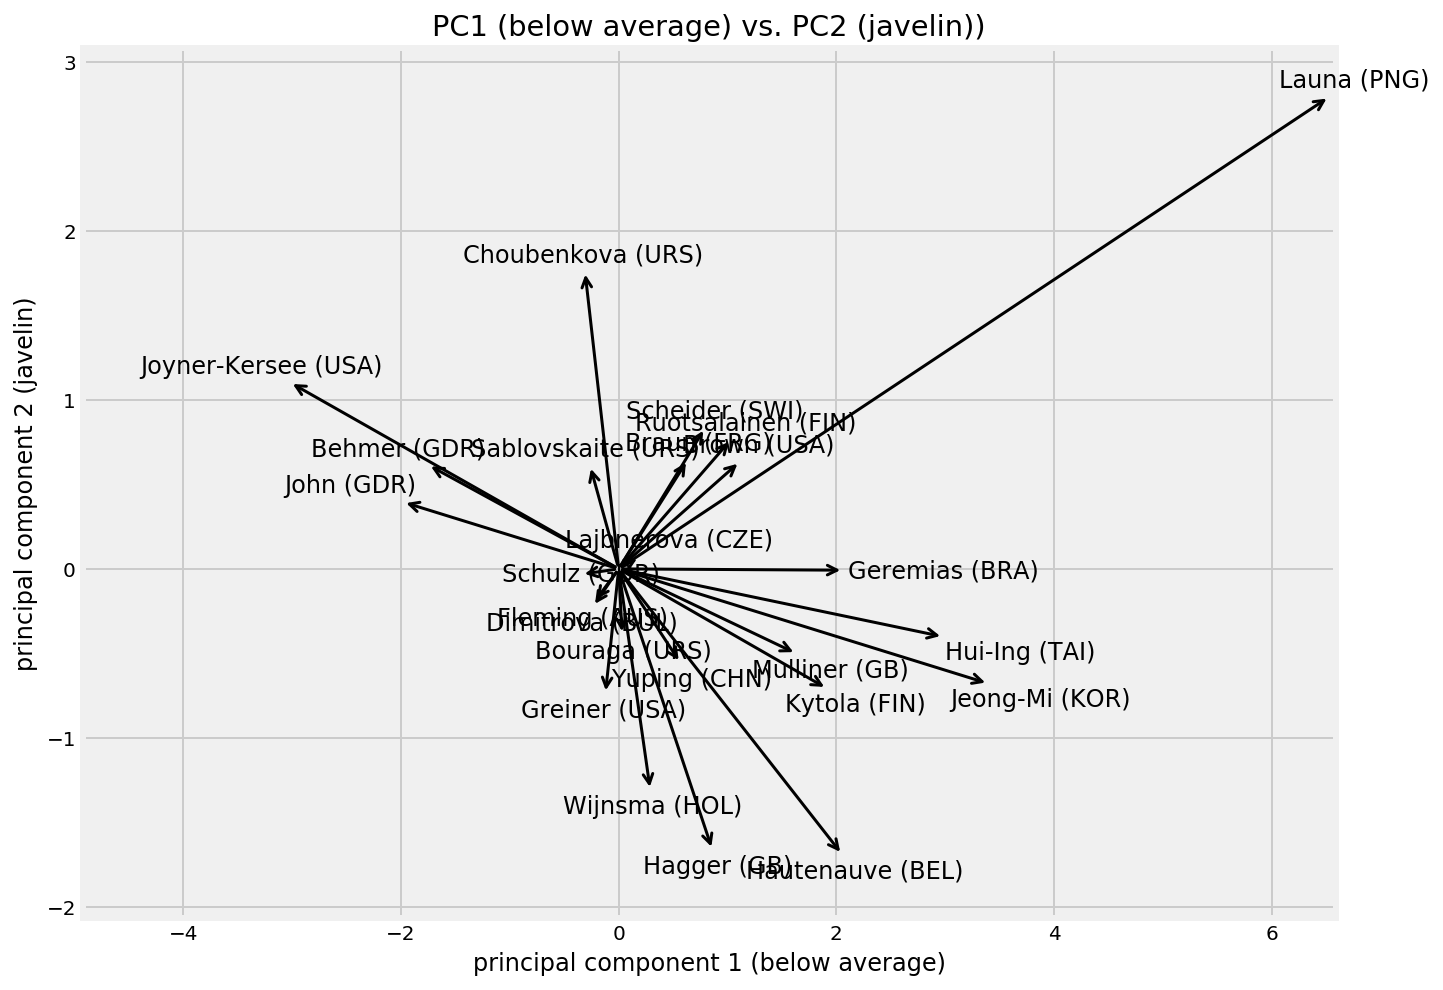

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pcs.PC1.values, pcs.PC2.values, s=0)

for i, txt in enumerate(pcs.index.values):
    ax.annotate(txt, (0, 0), (pcs.PC1.values[i], pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 (below average#changetowhatpc is explaining) vs. PC2 (javelin#changetowhatpc is explaining))')
ax.set_xlabel('principal component 1 (#changetofeaturepc1 is weighing on)')
ax.set_ylabel('principal component 2 (#changetofeaturepc2 is weighing on)')
plt.show()

---

### 10) Plot PC1 versus score. Do our results make sense?

Remember: **Always interpret your results**. Because we claimed that PC1 described "below average" athletes, we would guess that a larger PC1 value would have a lower score.

Let's graph it below and see if the scores agree with our intuition.

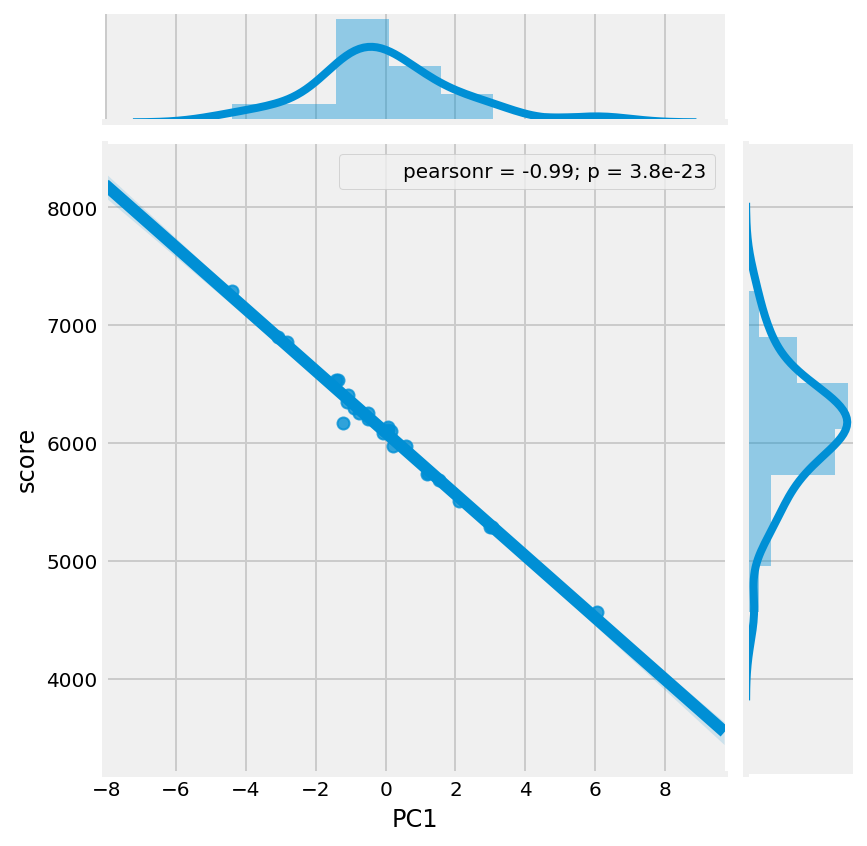

In [44]:
sns.jointplot(hep_pcs.PC1, hep_pcs.score, hep_pcs, kind="reg")

**Does this graph align with our guess from above?** If not, either our calculations or interpretation are likely incorrect. Thinking about the principal components allows us to provide evidence that our results are correct and helps us better understand the PCA results.

---

### 10.A) Plot PC2 versus score. What does this tell you about the relationship between the events and the score?

Consider how an athlete's score would be affected if they are better at javelin (our interpretation of PC2). After you understand how score _should be_ affected by PC2, look at the graph below. Does it align with your expectation?

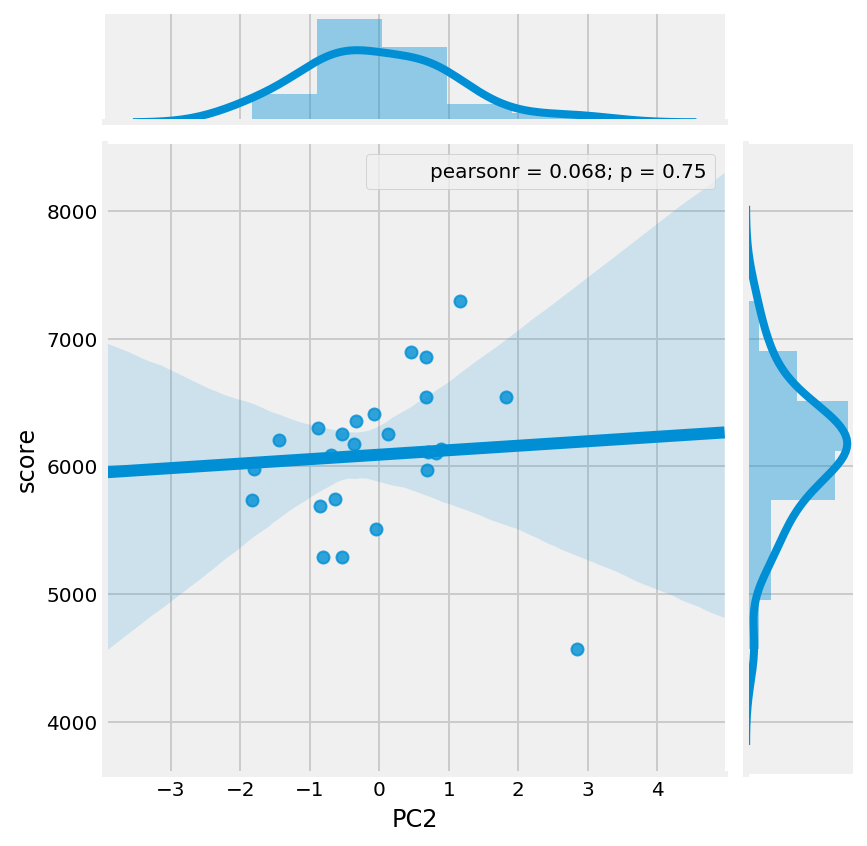

In [45]:
sns.jointplot(hep_pcs.PC2, hep_pcs.score, hep_pcs, kind="reg")

**Tip:** Notice that we have an outlier in the bottom-right corner. Outliers are either genuine or an indicator of bad data. It's typically useful to find the athlete who corresponds with each outlier to determine if the data are bad.

---

<a id="partii"></a>
# Part II: Wine Quality Data Set

Now it's your turn! Try repeating this analysis to investigate the wine quality data set. As much as possible, try to perform the analysis without looking at what we did above. Remember that most of what we did previously was manipulating Pandas data and plotting.


### 1) Load the wine quality data set.

In [71]:
wine = pd.read_csv('./datasets/wine_quality.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


---

### 2) Subset the wine data to everything except the `red_wine` column.

In [72]:
X = wine.drop('red_wine', axis=1)

---

### 3) Examine the correlation between variables.

In [73]:
X.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485


---

### 4) Standardize the variables.

In [75]:
Xs = StandardScaler().fit_transform(X)
Xs = pd.DataFrame(Xs, columns = X.columns.values)

---

### 5) Fit a PCA on the standardized data.

Create a new DataFrame with the principal components and the `red_wine` column added back in from the original data.

In [77]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

---

### 6) Create a DataFrame with the principal components.


In [78]:
pd.DataFrame(pca.components_, columns=X.columns)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.256929,-0.394931,0.146461,0.318905,-0.313450,0.422691,0.474420,-0.092438,-0.208070,-0.299852,-0.058924,0.087476
1,0.261843,0.105198,0.144093,0.342585,0.269770,0.111179,0.143948,0.554920,-0.152922,0.119634,-0.492727,-0.296601
2,0.467486,-0.279689,0.588076,-0.075502,0.046769,-0.098998,-0.101281,-0.051563,-0.406787,0.168691,0.212931,0.295838
3,-0.143964,-0.080058,0.055510,0.112456,0.165290,0.303306,0.132232,0.150579,0.471478,0.588020,0.080032,0.472439
4,0.165363,0.147774,-0.234621,0.507921,-0.393897,-0.248452,-0.223967,0.330357,-0.001458,-0.193246,0.116023,0.459129
5,-0.030037,0.382664,-0.362248,0.063317,0.425442,0.283180,0.106769,-0.154553,-0.560897,0.020141,0.169475,0.277888
6,0.393435,0.445111,0.047698,-0.095763,-0.473296,0.362714,0.234813,0.013286,0.079321,0.170236,0.338906,-0.273177
7,-0.001155,-0.310078,-0.444962,-0.081945,-0.375532,-0.120098,-0.011279,-0.042944,-0.362282,0.592221,-0.226041,-0.093046
8,-0.424169,0.123233,0.246233,0.488024,0.044050,-0.301397,-0.001814,-0.071081,-0.136662,0.297401,0.417060,-0.356647
9,0.272432,-0.493946,-0.330355,0.207174,0.238873,0.303448,-0.294780,0.076815,0.112409,-0.085469,0.416059,-0.307830


---

### 7) Plot the explained variance (ratio) of the components.

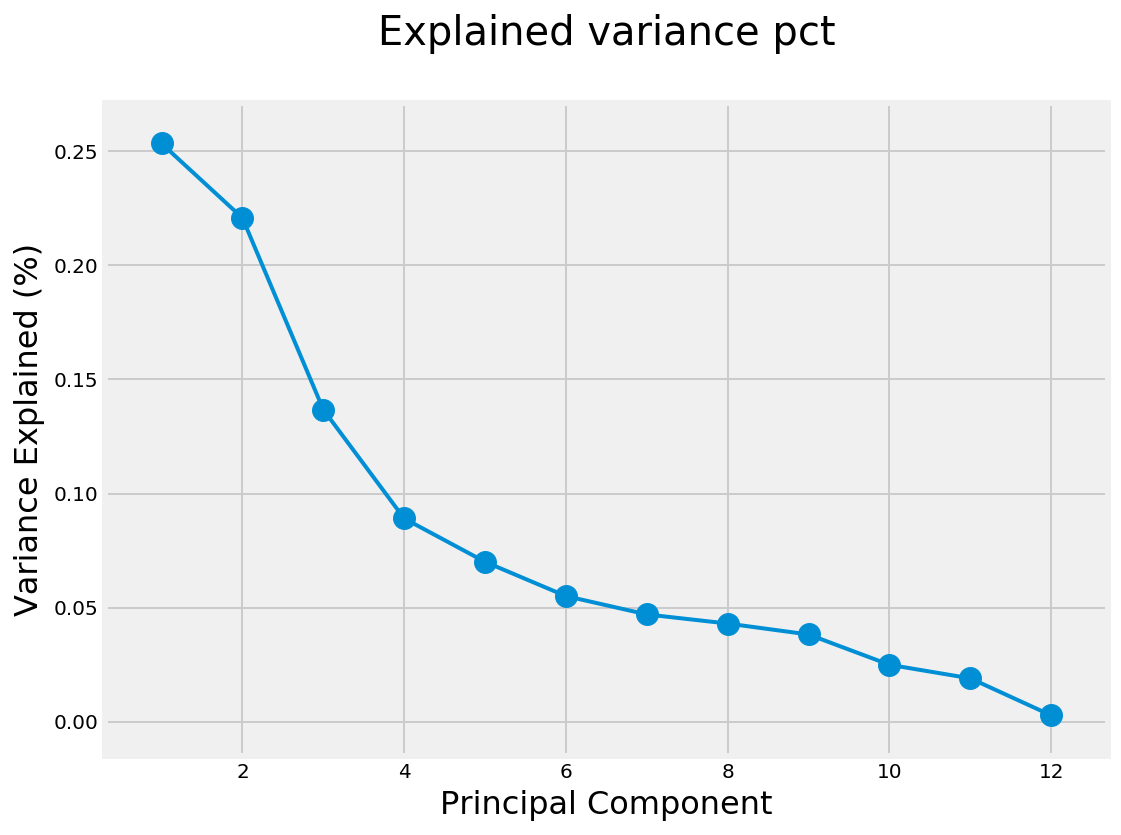

In [80]:
exp_var = pca.explained_variance_ratio_
exp_var
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()

---

### 8) Print out the component weights with their corresponding variables for PC1, PC2, and PC3.

How would you label the components based on their weights?

In [81]:
pd.DataFrame(pca.components_, columns=X.columns)[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.256929,-0.394931,0.146461,0.318905,-0.313450,0.422691,0.474420,-0.092438,-0.208070,-0.299852,-0.058924,0.087476
1,0.261843,0.105198,0.144093,0.342585,0.269770,0.111179,0.143948,0.554920,-0.152922,0.119634,-0.492727,-0.296601
2,0.467486,-0.279689,0.588076,-0.075502,0.046769,-0.098998,-0.101281,-0.051563,-0.406787,0.168691,0.212931,0.295838


In [83]:
#getting PC columns
pcs = pca.transform(Xs)
pcs = pd.DataFrame(pcs, 
                       columns=['PC'+str(i+1) for i in range(len(X.columns))],
                       index=X.index)
pcs['red_wine'] = wine['red_wine']
pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,red_wine
0,-3.348438,0.568926,-2.727386,-0.223777,0.621408,-0.231602,0.124851,-0.000515,-0.646268,-0.069141,-0.104249,0.027643,1
1,-3.228595,1.197335,-1.998904,-0.377154,0.110313,1.945885,0.938413,0.425532,-0.114802,-0.449160,-0.258251,-0.014469,1
2,-3.237468,0.952580,-1.746578,-0.472791,0.225404,1.082561,0.451976,0.411350,-0.120635,-0.272888,-0.081613,0.053961,1
3,-1.672561,1.600583,2.856552,-0.438364,0.213093,-0.970765,0.222429,-0.279690,-1.294900,0.212574,0.120527,-0.100574,1
4,-3.348438,0.568926,-2.727386,-0.223777,0.621408,-0.231602,0.124851,-0.000515,-0.646268,-0.069141,-0.104249,0.027643,1


**Note:** It's interesting to research what causes these factors in wines. For example, is sulfur dioxide added to wine or is it a natural byproduct of its ingredients? What affects how much sulfur dioxide a winemaker might add to wine? 

By researching these questions, you can likely find a good explanation for these principal components — beyond a bland description of the weightings. You can also use these intuitions from research (e.g., how pH and residual sugar affect sulfur dioxide) to provide evidence of the principal components' validity.

---

### 9) Plot PC1 versus PC2.

- Use a regular scatterplot.
- Vary the alpha value to see better densities.

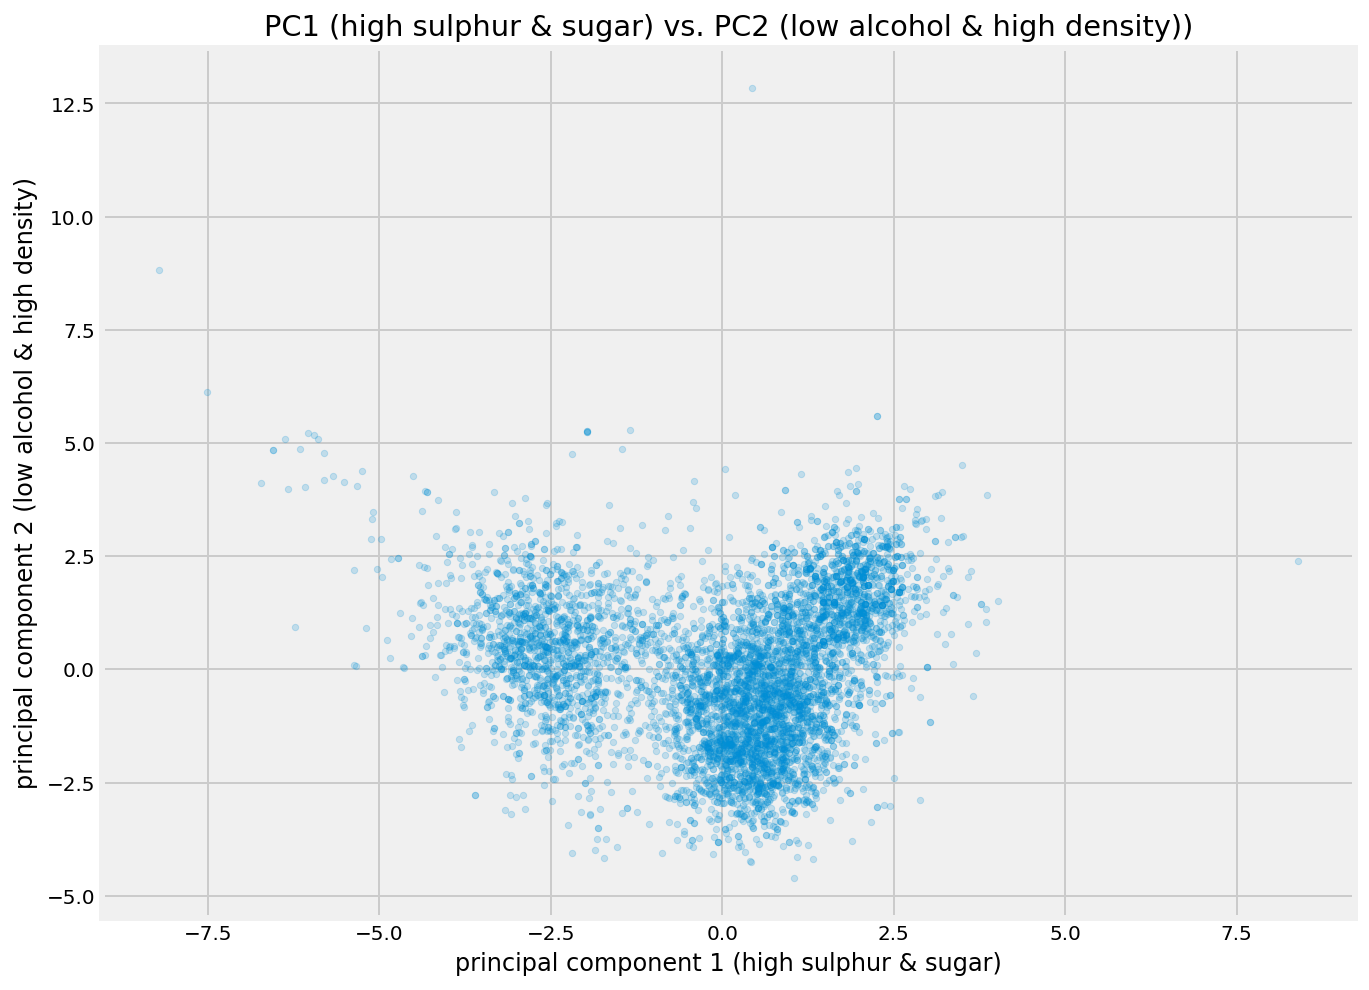

In [99]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pcs.PC1.values, pcs.PC2.values, s=10, alpha=0.2)
ax.set_title('PC1 (high sulphur & sugar) vs. PC2 (low alcohol & high density))')
ax.set_xlabel('principal component 1 (high sulphur & sugar)')
ax.set_ylabel('principal component 2 (low alcohol & high density)')
plt.show()


---

### 10. Plot a Seaborn pair plot of PC1, PC2, and PC3 with `hue='red_wine'`.

Do any of the components differentiate red and white wine? If so, what does this tell you about the difference between red and white wine based on the component weights? Does each plot align with your expectations based on the components?

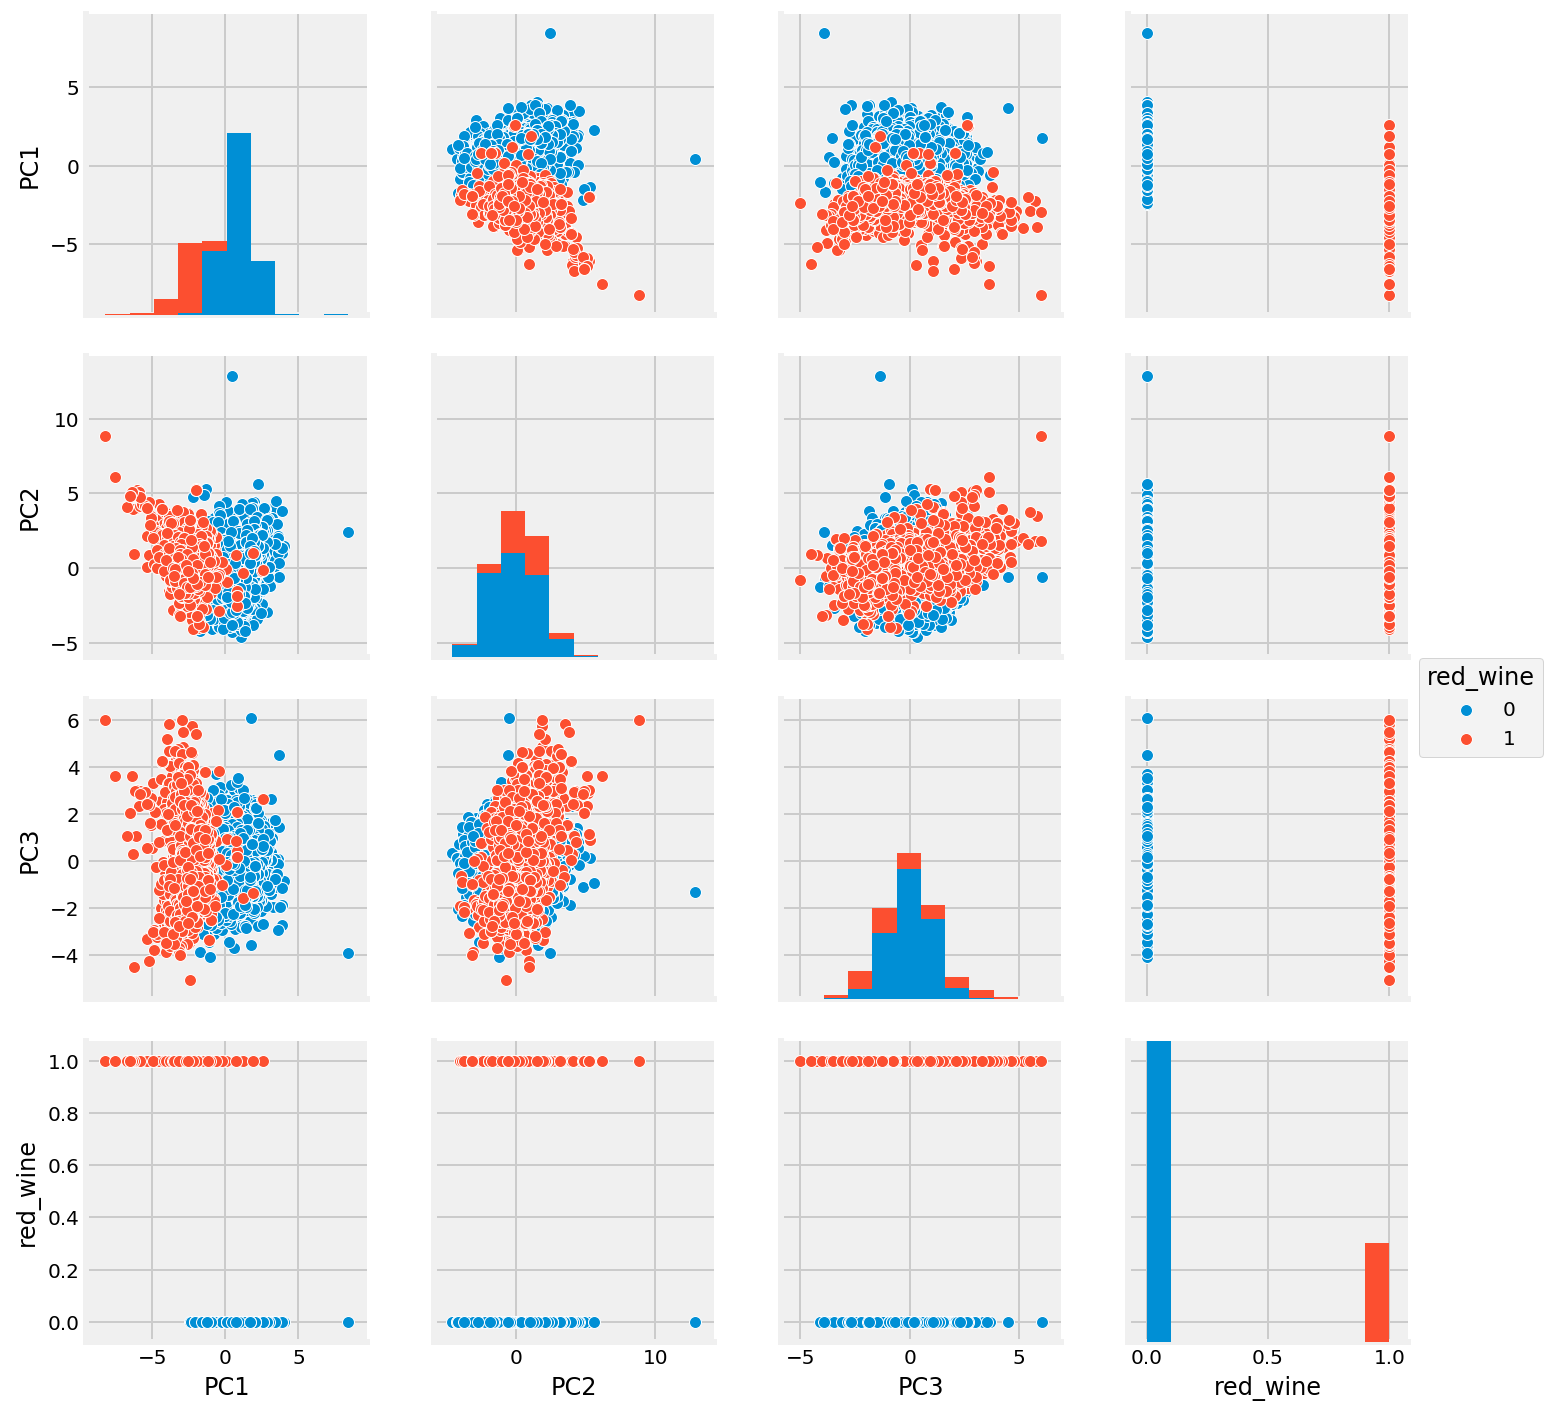

In [106]:
sns.pairplot(pcs.loc[:,['PC1','PC2','PC3','red_wine']], hue='red_wine')

In [ ]:
sns.pairplot(pcs.loc[:,['PC1','PC2','PC3','target']], hue='target')

---

<a id="partiii"></a>
# Part III: Horn's Parallel Analysis

You can determine the appropriate number of components to keep by using a bootstrapping procedure known as Horn's parallel analysis. This is the gold standard in determining which components aren't noise.

How to perform the parallel analysis (pseudocode):

    For n iterations:
        Create normally distributed random data that are the same shape as your data.
        Fit a PCA on the random data.
        Pull out the eigenvalues.
    Select a percentile of the eigenvalues as your threshold (0.5 = median, 0.95 = 95 percent confidence, etc.).
    Plot the random component eigenvalues at that percentile against your data's PCA eigenvalues.
    Components above the selected percentile are not noise; those that are under are.
   
Ultimately, we are comparing the PCA-explained variance of your data set against the PCA-explained variance of random Gaussian functions. If your PCA's explained variance is lower than that of random Gaussians, then we’ll assume these components represent noise.

--- 

### 1) Write a function to perform the parallel analysis.

In [107]:
# Replace with the actual algorithm.
def horn_parallel_analysis(shape, iters=1000, percentile=95):
    np.random.normal()
    return [0.0] * shape[1]

---

### 2) Run parallel analysis for the heptathlon data.

In [110]:
# This should work automatically (for 95th percentile).
hep_pa = horn_parallel_analysis(X.shape, percentile=95)
hep_pa

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### 3) Run parallel analysis for the wine data.

In [15]:
# This should work automatically (for 95th percentile).
wine_pa = horn_parallel_analysis(X.shape, percentile=95)
wine_pa

---

### 4) Plot the wine eigenvalues (`.variance_explained_`) against the parallel analysis random eigenvalue cut-offs.

How many components are not noise, based on the chart?

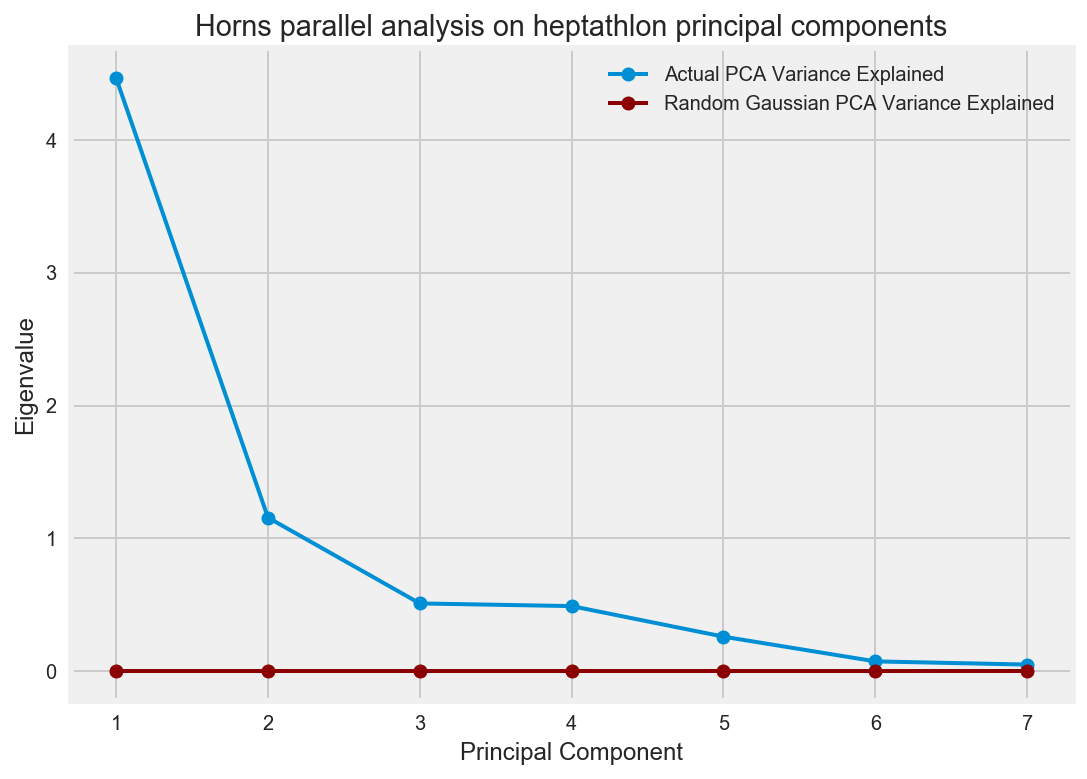

In [116]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, X.shape[1]+1), pca.explained_variance_, lw=2, marker='o')
ax.plot(range(1, X.shape[1]+1), hep_pa, lw=2, color='darkred', marker='o')

ax.set_title("Horns parallel analysis on heptathlon principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")

plt.legend(['Actual PCA Variance Explained', "Random Gaussian PCA Variance Explained"])
plt.show()

**Conclusion:** Note that the actual variance explained is lower than the variance explained of the random Gaussian variance after PC1. Hence, a reasonable set of principal components would be the first.

---

### 5) Plot the wine eigenvalues (`.variance_explained_`) against the parallel analysis random eigenvalue cut-offs.

In [16]:
# A: